## Figures

- Figure 5 C
- Figure S6 B,C
- Supplementary movie 1

## Required files
- `{models_dir}/{exp}/motif-simulation/spacing;correct=True.pkl`
- `{models_dir}/{exp}/motif-simulation/spacing;correct=False.pkl`

## Produced files

`fdir = f'{ddir}/figures/modisco/{exp}/spacing/'`

- Figure 5C
  - `{fdir}/simulated.short-range.Nanog<>Sox2.strand_orientation={strand}.pdf`
  - `{fdir}/simulated.long-range.Oct4-Sox2.strand_orientation={strand}.pdf`
- Figure S6C
  - `{fdir}/all-pairs.bleed-through-corrected.strand-specific.pdf`
- Supplementary movie 1
  - `{fdir}/gifs/{motif_pair_name}.gif`

In [1]:
from collections import OrderedDict
exp = 'nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE'
imp_score = 'profile/wn'

motifs = OrderedDict([
    ("Oct4-Sox2", 'Oct4/m0_p0'),
    ("Oct4", "Oct4/m0_p1"),
    ("Oct4-Oct4", "Oct4/m0_p6"),
    ("Sox2", "Sox2/m0_p1"),
    ("Nanog", "Nanog/m0_p1"),
    ("Nanog-alt", "Nanog/m0_p4"),
    ("Klf4", "Klf4/m0_p0"),
    ("Klf4-long", "Klf4/m0_p5"),
    ("B-box", "Oct4/m0_p5"),
    ("Zic3", "Nanog/m0_p2"),
    ("Essrb", "Oct4/m0_p16"),
])


In [2]:
profile_mapping={k: v.split("/")[0] for k,v in motifs.items()}

### Load the model

In [3]:
from basepair.imports import *
from basepair.exp.paper.config import *
from basepair.exp.chipnexus.spacing import remove_edge_instances, get_motif_pairs, motif_pair_dfi

Using TensorFlow backend.


In [4]:
# figures dir
model_dir = models_dir / exp
fdir = Path(f'{ddir}/figures/modisco/{exp}/spacing/')

In [5]:
%config InlineBackend.figure_format = 'retina'

In [6]:
paper_config()

In [7]:
import os
import pandas as pd
import types
import numpy as np
from basepair.seqmodel import SeqModel
from basepair.BPNet import BPNetSeqModel
from collections import OrderedDict
from basepair.preproc import rc_seq
from basepair.exp.chipnexus.simulate import (insert_motif, generate_sim, plot_sim, generate_seq,
                                             model2tasks, motif_coords, interactive_tracks, plot_motif_table,
                                             plot_sim_motif_col)
from concise.preprocessing import encodeDNA
from basepair.exp.paper.config import models_dir
from basepair.config import get_data_dir, create_tf_session
from basepair.utils import write_pkl
import argparse
import logging
logger = logging.getLogger(__name__)
logger.addHandler(logging.NullHandler())


# --------------------------------------------
# Motif configuration
motif_seqs = OrderedDict([
    ("Oct4-Sox2", 'TTTGCATAACAA'),
    ("Oct4", "TATGCAAAT"),
    ("Oct4-Oct4", "TATGCATATGCATA"),
    ("Sox2", "GAACAATGG"),
    ("Nanog", "AGCCATCA"),
    ("Nanog-alt", "GATGGCCCATTTCCT"),
    ("Klf4", "CCACGCCC"),
    ("Klf4-long", "GCCCCGCCCCGCCC"),
    ("B-box", "CCGGGGTTCGAACCCGGG"),
    ("Zic3", "TCTCAGCAGGTAGCA"),
    ("Essrb", "TGACCTTGACCTT")
])

# get also the rc motifs
rc_motif_seqs = OrderedDict([
    (m + "/rc", rc_seq(v))
    for m, v in motif_seqs.items()
])
all_motif_seqs = OrderedDict(list(motif_seqs.items()) + list(rc_motif_seqs.items()))

center_coords = [485, 520]
repeat = 128

## In silico instances

In [147]:
!ls {models_dir}/{exp}/motif-simulation/

spacing;correct=True.pkl  spacing;correct=True.pkl.bak	spacing;correct=False.pkl


In [12]:
# corrected
sim_df_d_norm, sim_res_dict_d_norm = read_pkl(f"{models_dir}/{exp}/motif-simulation/spacing;correct=True.pkl")

## Visualize motif pairs

In [29]:
from basepair.exp.chipnexus.spacing import comp_strand_compbination

def get_xy_sim_single(sim_df_d, motif_pair, feature, orientation, profile_mapping):
    # For Nanog, always explicilty swap the orientation
    orientation_pair = [orientation[0], orientation[1]]
    
    mp = list(deepcopy(motif_pair))
    if orientation_pair[0] == "-":
        mp[0] = mp[0] + "/rc"
    if orientation_pair[1] == "-":
        mp[1] = mp[1] + "/rc"
        
    df = sim_df_d[mp[0]]  # choose the central motif
    df = df[df.motif == mp[1]]  # choose the side motif
    
    df = df[df.distance < 150]
    
    # select the task
    df = df[df.task == profile_mapping[motif_pair[0]]]        
    return df.distance.values, df[feature].values
    
def get_xy_sim(sim_df_d, motif_pair, feature, orientation, profile_mapping):
    x1,y1 = get_xy_sim_single(sim_df_d, motif_pair, feature, orientation, profile_mapping)
    x2,y2 = get_xy_sim_single(sim_df_d, list(reversed(motif_pair)), feature, orientation, profile_mapping)
    return x1, y1, y2

In [ ]:
pairs = get_motif_pairs(motifs)

In [ ]:
tested_motif_pairs = [p for p in pairs if p[0] in sim_df_d_norm and p[1] in sim_df_d_norm]

## Figure 5B

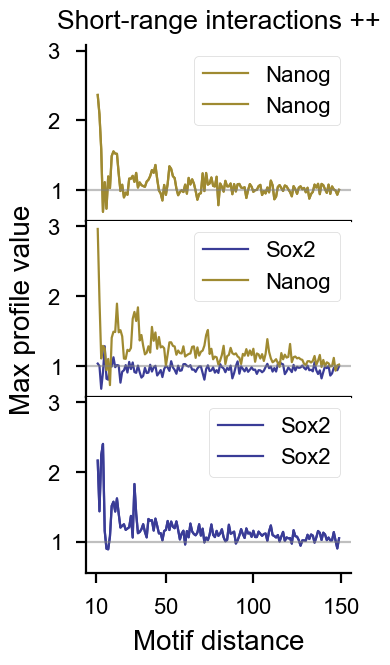

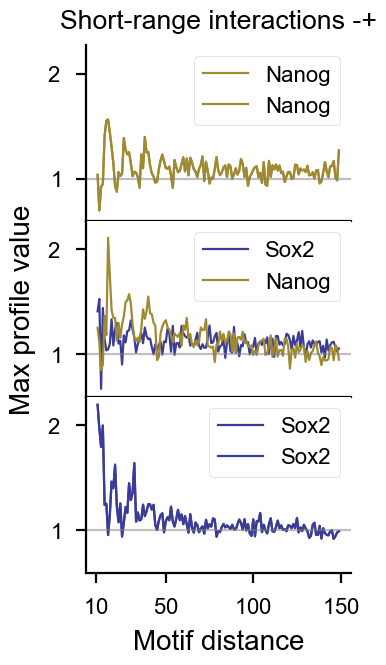

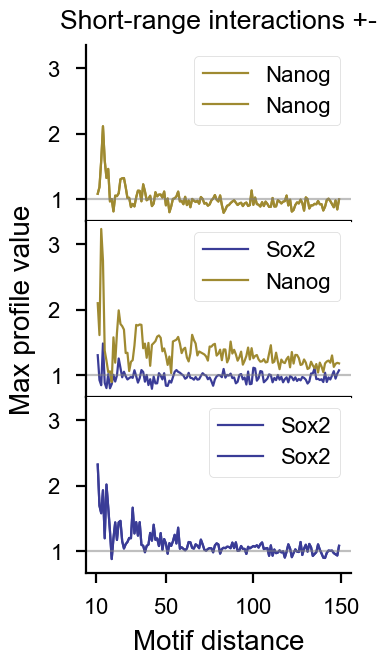

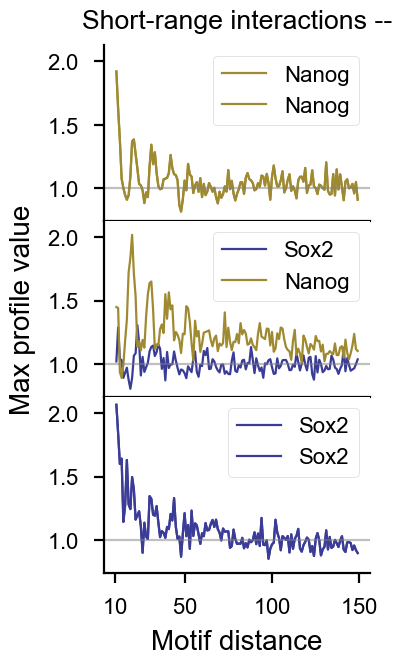

In [43]:
for strand in ['++', '-+', '+-', '--']:
    fig, axes = plt.subplots(3, 1, figsize=get_figsize(.25, 2), 
                             sharex=True, 
                             sharey=True,
                             gridspec_kw=dict(wspace=0, hspace=0))
    # motif_pair = ['Oct4-Sox2', 'Sox2']
    for i, motif_pair in enumerate([['Nanog', 'Nanog'], 
                                    ['Sox2', 'Nanog'],
                                    ['Sox2', 'Sox2']]):
        x, y, y2 = get_xy_sim(sim_df_d_norm, motif_pair, 'profile/counts_max_ref_frac', strand, profile_mapping)
        ax = axes[i]
        ax.plot(x, y, label=motif_pair[0], color=tf_colors[profile_mapping[motif_pair[0]]]);
        ax.plot(x, y2, label=motif_pair[1], color=tf_colors[profile_mapping[motif_pair[1]]]);
        if i == 0:
            ax.set_title(f"Short-range interactions {strand}")
        ax.axhline(1, color='grey', alpha=0.5)
        if i == 1:
            ax.set_ylabel("Max profile value")
        ax.legend()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    axes[-1].set_xlabel("Motif distance")
    axes[-1].set_xticks([10, 50, 100, 150]);
    fig.savefig(fdir / f'simulated.short-range.Nanog<>Sox2.strand_orientation={strand}.pdf')

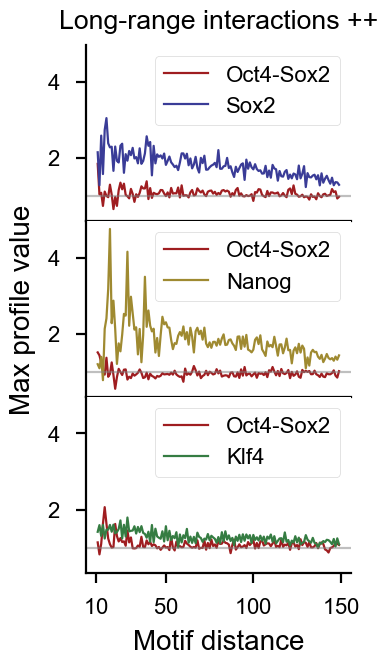

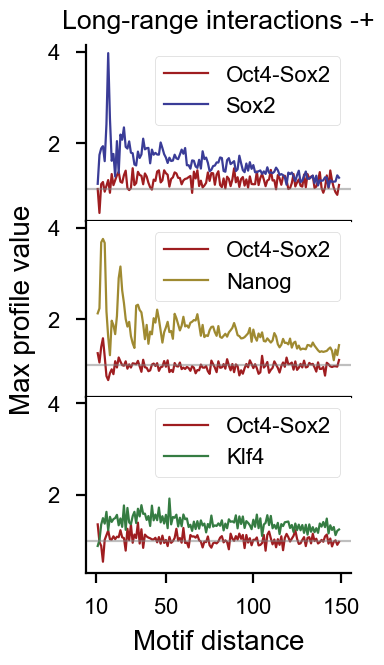

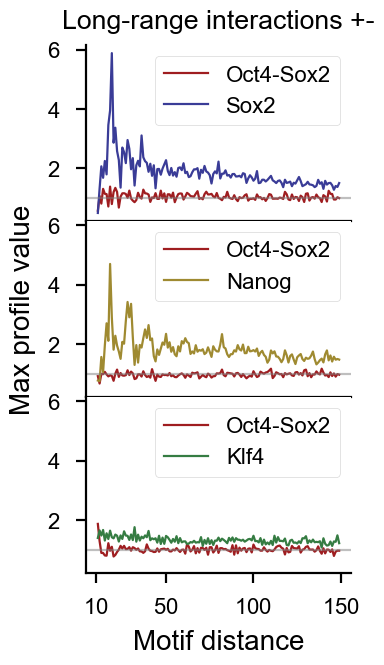

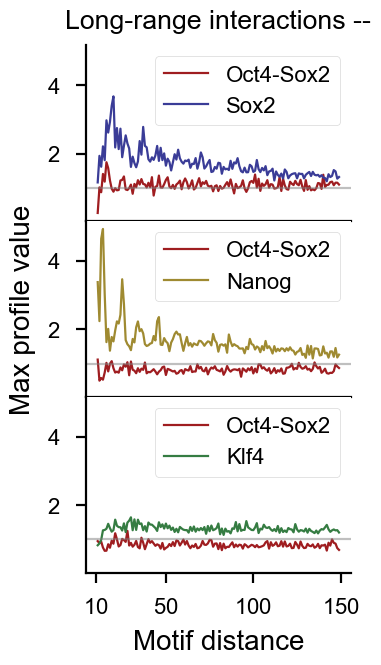

In [45]:
for strand in ['++', '-+', '+-', '--']:

    fig, axes = plt.subplots(3, 1, figsize=get_figsize(.25, 2), 
                             sharex=True, 
                             sharey=True,
                             gridspec_kw=dict(wspace=0, hspace=0))
    # motif_pair = ['Oct4-Sox2', 'Sox2']
    for i, motif_pair in enumerate([['Oct4-Sox2', 'Sox2'], 
                                    ['Oct4-Sox2', 'Nanog'],
                                    ['Oct4-Sox2', 'Klf4']]):
        x, y, y2 = get_xy_sim(sim_df_d_norm, motif_pair, 'profile/counts_max_ref_frac', strand, profile_mapping)
        ax = axes[i]
        ax.plot(x, y, label=motif_pair[0], color=tf_colors[profile_mapping[motif_pair[0]]]);
        ax.plot(x, y2, label=motif_pair[1], color=tf_colors[profile_mapping[motif_pair[1]]]);
        if i == 0:
            ax.set_title(f"Long-range interactions {strand}")
        ax.axhline(1, color='grey', alpha=0.5)
        if i == 1:
            ax.set_ylabel("Max profile value")
        ax.legend()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    axes[-1].set_xlabel("Motif distance")
    axes[-1].set_xticks([10, 50, 100, 150]);
    fig.savefig(fdir / f'simulated.long-range.Oct4-Sox2.strand_orientation={strand}.pdf')

## Generate per-motif plots

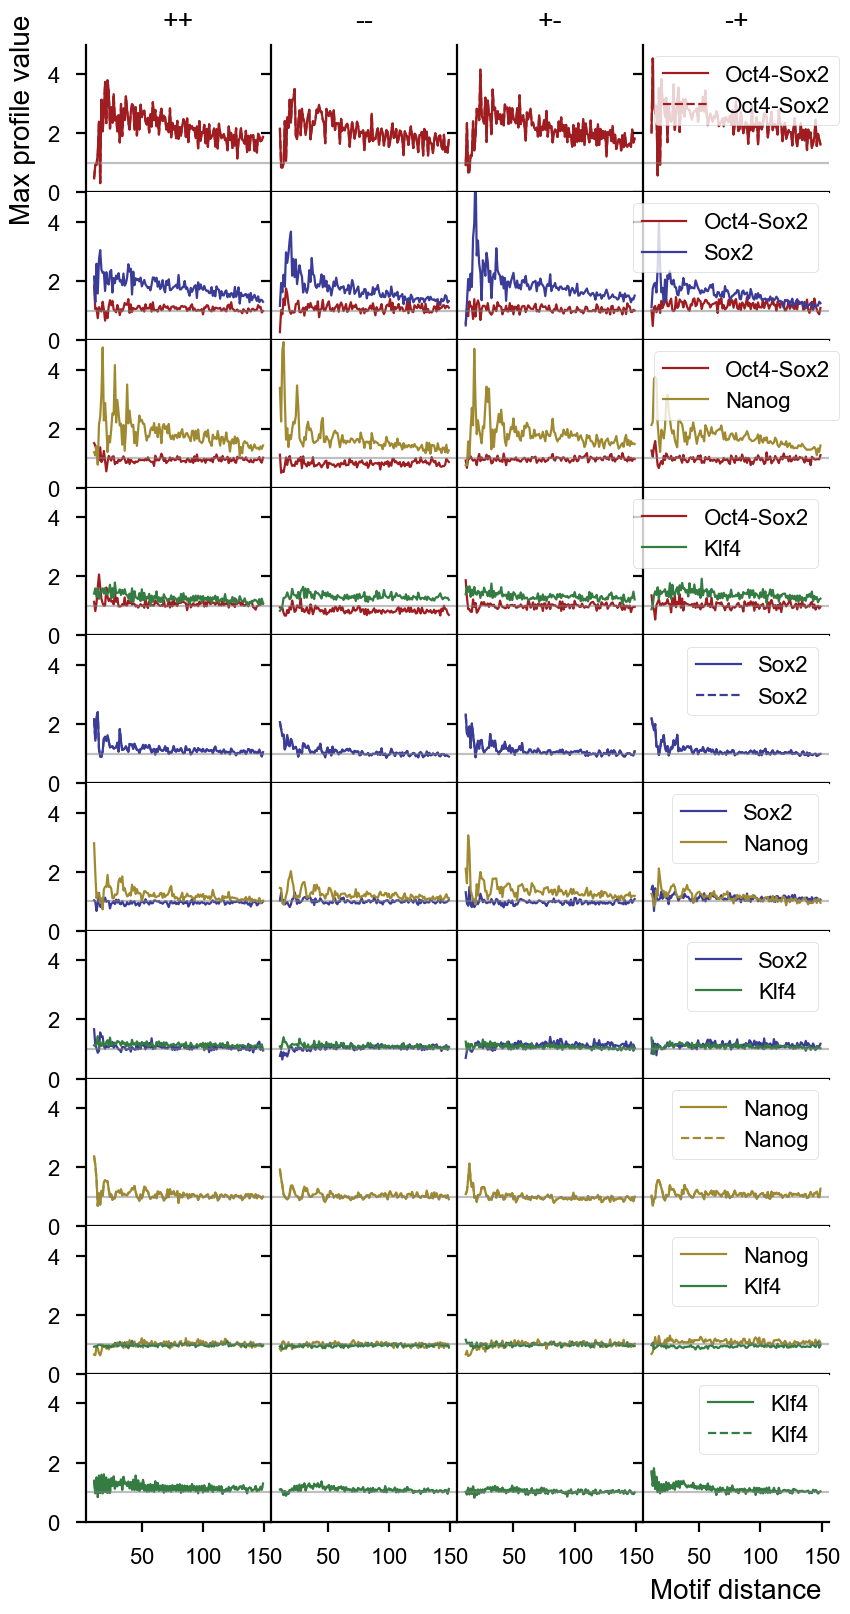

In [32]:
ymax = 5
columns = 4
plot_pairs = get_motif_pairs(['Oct4-Sox2', 'Sox2', 'Nanog', 'Klf4'])
rows = len(plot_pairs)
fig, axes = plt.subplots(rows, columns, figsize=get_figsize(.7, 1/5*len(plot_pairs)), 
                         sharex=True, 
                         sharey=True,
                         gridspec_kw=dict(wspace=0, hspace=0))

for j, motif_pair in enumerate(plot_pairs):
    for i, strand_orientation in enumerate(['++', '--', '+-', '-+']):
        x, y, y2 = get_xy_sim(sim_df_d_norm, motif_pair, 'profile/counts_max_ref_frac', strand_orientation, profile_mapping)
        ax = axes[j, i]
        ax.plot(x, y, label=motif_pair[0], color=tf_colors[profile_mapping[motif_pair[0]]]);
        ax.plot(x, y2, label=motif_pair[1], color=tf_colors[profile_mapping[motif_pair[1]]], 
                linestyle='dashed' if motif_pair[0] == motif_pair[1] else 'solid');  # only dashed for homotypic interactions
        ax.set_ylim([0, ymax])
        ax.axhline(1, color='grey', alpha=0.5)
        if j == 0:
            ax.set_title(strand_orientation)
            if i ==0 :
                ax.set_ylabel("Max profile value")
            
        if i == 3:
            ax.legend()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if i % rows == rows-1:
            axes[i].set_xticks([10, 50, 100, 150]);
ax.set_xlabel("Motif distance")
motif_pair_name = '<>'.join(motif_pair)
fig.savefig(fdir / f'all-pairs.bleed-through-corrected.strand-specific.pdf')

In [84]:
from basepair.exp.chipnexus.simulate import generate_seq

In [90]:
# Best sequence: AGCCATCANNNAGCCATCA

In [91]:
# Worst sequence: AGCCATCANNNNNNAGCCATCA

## Spacing movie

In [13]:
# Non-corrected
sim_df_d, sim_res_dict_d = read_pkl(f"{models_dir}/{exp}/motif-simulation/spacing;correct=False.pkl")

In [99]:
from basepair.plot.tracks import plot_track

def plot_track_rev(arr, ax, legend=False, ylim=None, color=None, alpha=None, track=None):
    """Plot a track
    """
    seqlen = len(arr)
    if arr.ndim == 1 or arr.shape[1] == 1:
        # single track
        if color is not None:
            if isinstance(color, collections.Sequence):
                color = color[0]
        ax.plot(np.arange(1, seqlen + 1), np.ravel(arr), color=color)
    elif arr.shape[1] == 4:
        # plot seqlogo
        seqlogo(arr, ax=ax)
    elif arr.shape[1] == 2:
        # plot both strands
        if color is not None:
            assert isinstance(color, collections.Sequence)
            c1 = color[0]
            c2 = color[1]
        else:
            c1, c2 = None, None
            
        if alpha is not None:
            assert isinstance(alpha, collections.Sequence)
            a1 = alpha[0]
            a2 = alpha[1]
        else:
            a1, a2 = None, None
            
        ax.plot(np.arange(1, seqlen + 1), arr[:, 0], label='pos', color=c1, alpha=a1)
        ax.plot(np.arange(1, seqlen + 1), -arr[:, 1], label='neg', color=c2, alpha=a2)
        if legend:
            ax.legend()
    else:
        raise ValueError(f"Don't know how to plot array with shape[1] != {arr.shape[1]}. Valid values are: 1,2 or 4.")
    if ylim is not None:
        ax.set_ylim(ylim)

motif_pairs_sim = [
    ('Nanog', 'Nanog'),
    ('Nanog', 'Sox2'),
    ('Sox2', 'Sox2'),
    ('Sox2', 'Oct4-Sox2'),
    ('Nanog', 'Oct4-Sox2'),
    ('Klf4', 'Oct4-Sox2'),
]
profile_mapping

distance_range = np.arange(11, 161)

In [15]:
def get_motif_pair(data, pair, profile_mapping, dist):
    dist_val, profiles = data[pair[0]][pair[1]][1][dist - 11]
    assert dist + 500 == dist_val
    pair_track_names = (profile_mapping[pair[0]], profile_mapping[pair[1]])
    return {tn: profiles['profile'][tn]
            for tn in pair_track_names}

In [16]:
# compute the maximal values across all the possible situations
max_vals = {}
for dist in distance_range:
    for motif_pair in motif_pairs_sim:
        profiles = get_motif_pair(sim_res_dict_d, motif_pair, profile_mapping, dist)
        for k,v in profiles.items():
            if v.max() > max_vals.get(k, 0):
                max_vals[k] = v.max()

In [ ]:
create_tf_session(3)
bpnet = BPNetSeqModel.from_mdir(model_dir)

In [17]:
# compute the control bias
x_none = bpnet.sim_pred('')
control_bias = {k.split("/")[1]: x_none[k].mean(axis=-1, keepdims=True)/ x_none[k].mean(axis=-1, keepdims=True).max()
                for k in x_none}

In [66]:
distance_range

array([ 11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30, ..., 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160])

In [95]:
!mkdir -p {fdir}/gifs

In [97]:
len(motif_pairs_sim)

6

  0%|          | 0/6 [00:00<?, ?it/s]2019-08-10 15:46:42,442 [INFO] Animation.save using <class 'matplotlib.animation.ImageMagickWriter'>
2019-08-10 15:46:42,443 [INFO] Disabling savefig.bbox = 'tight', as it may cause frame size to vary, which is inappropriate for animation.
2019-08-10 15:46:42,445 [INFO] MovieWriter.run: running command: ['convert', '-size', '1800x450', '-depth', '8', '-delay', '20.0', '-loop', '0', 'rgba:-', '/users/avsec/workspace/basepair/data/figures/modisco/nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE/spacing/gifs/Nanog<>Nanog.gif']
 17%|█▋        | 1/6 [00:19<01:37, 19.46s/it]2019-08-10 15:47:03,775 [INFO] Animation.save using <class 'matplotlib.animation.ImageMagickWriter'>
2019-08-10 15:47:03,778 [INFO] Disabling savefig.bbox = 'tight', as it may cause frame size to vary, which is inappropriate for animation.
2019-08-10 15:47:03,779 [INFO] MovieWriter.run: running command: ['convert', '-size', '1800x900', '-depth', '8', '-delay', '20

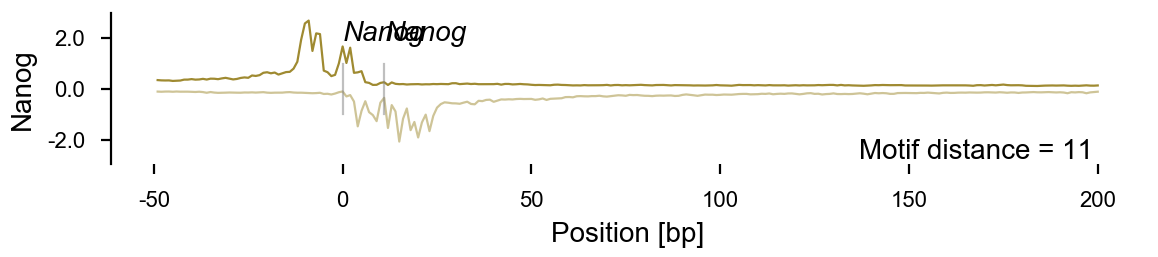

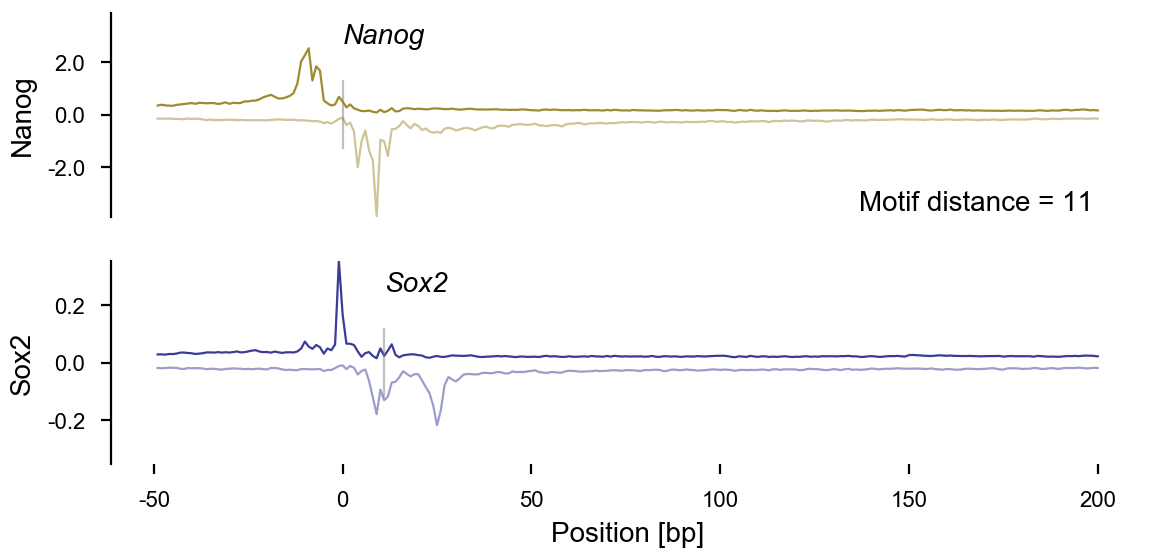

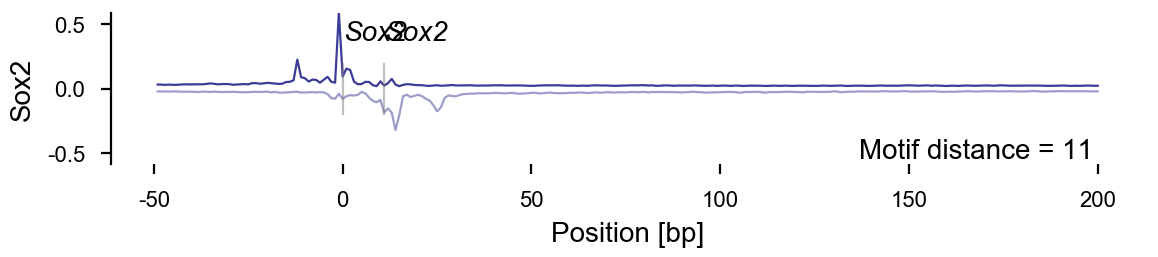

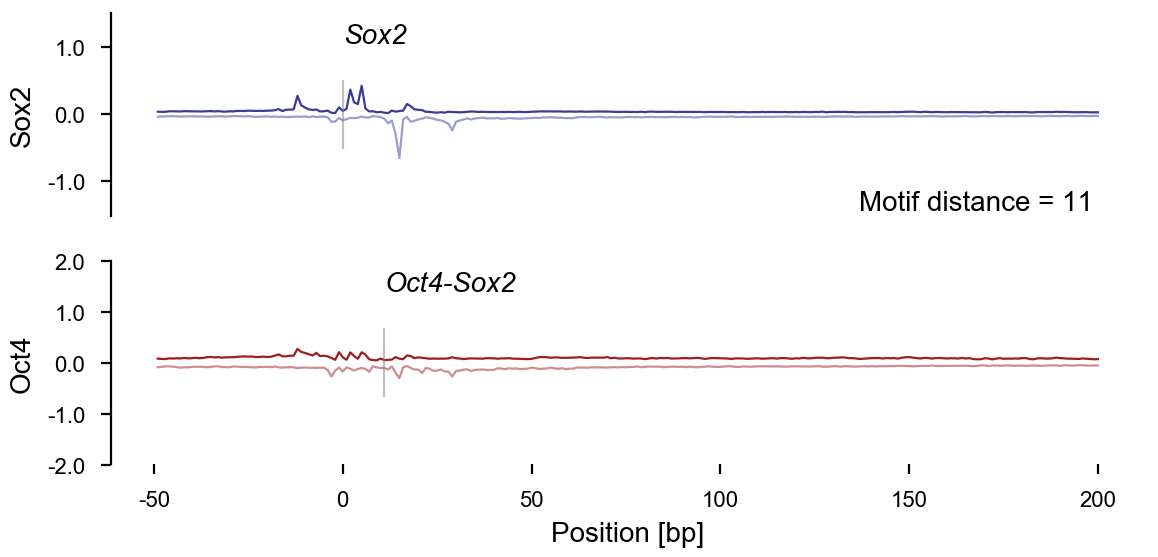

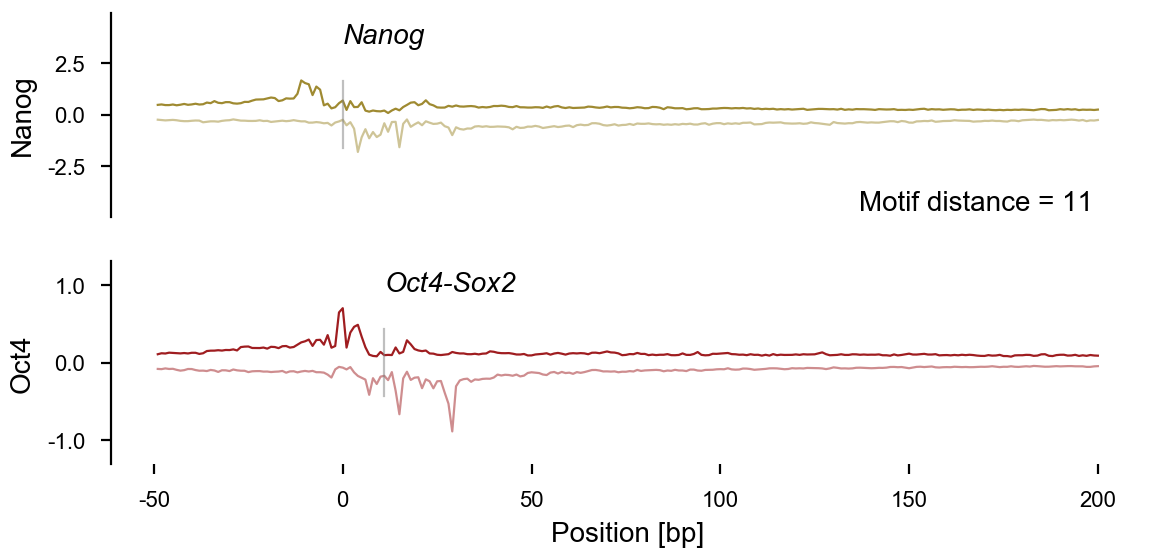

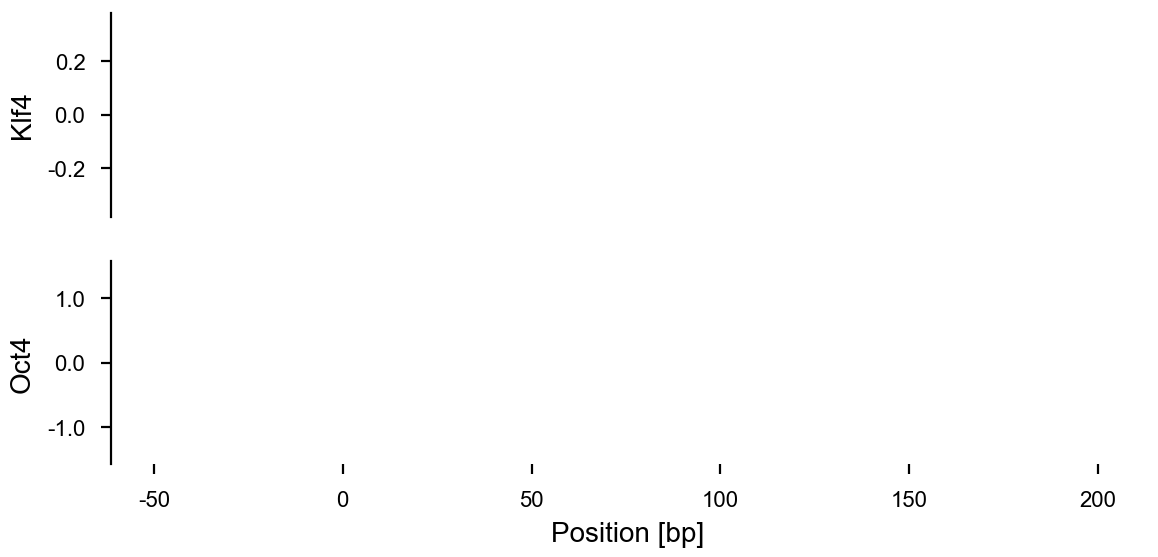

In [104]:
from celluloid import Camera
from IPython.display import HTML, Image
from matplotlib.ticker import FuncFormatter
from basepair.plot.tracks import *

# motif_pair = ('Nanog', 'Nanog')

for motif_pair in tqdm(motif_pairs_sim):
    
    motif_pair_name = "<>".join(motif_pair)
    
    max_vals = {}
    max_val_pos = {}
    for dist in distance_range:
        profiles = get_motif_pair(sim_res_dict_d, motif_pair, profile_mapping, dist)
        profiles = {k:v/control_bias[k] for k,v in profiles.items()}
        for k,v in profiles.items():
            if v.max() > max_vals.get(k, 0):
                max_vals[k] = v.max()
                max_val_pos[k] = dist

    
    fontsize = 10
    shift = 50

    fig, axes = plt.subplots(len(profiles), 1,
                             figsize=(6, 1.5 * len(profiles)),
                             sharex=True)
    if len(profiles) == 1:
        axes = [axes]
    camera = Camera(fig)

    # start from the outside in
    for i, distance in enumerate(reversed([11, 11] + list(range(11, 31, 1)) + list(range(31, 41, 2)) + list(range(41, 61, 4)) + list(range(61, 160, 8)))):

        profiles = get_motif_pair(sim_res_dict_d, motif_pair, profile_mapping, distance)
        profiles = {k:v/control_bias[k] for k,v in profiles.items()}  # normalize
        tracks = filter_tracks(profiles, xlim=[500 - shift, 500-shift + 250])

        # setup ylim
        ylim = [(-max_vals[k], max_vals[k]) for k in profiles]

        # plot the tracks
        for i, (ax, (track, arr)) in enumerate(zip(axes, get_items(tracks))):
            yl = get_list_value(ylim, i)
            plot_track_rev(arr, ax, legend=False, ylim=yl,
                           color=(tf_colors[track], tf_colors[track]),
                           alpha=(1, 0.5),
                           track=track)

            ax.set_ylabel(track)
            simple_yaxis_format(ax)
            if i != len(tracks) - 1:
                ax.xaxis.set_ticks_position('none')

        # add ticks to the final axis
        ax.xaxis.set_major_locator(ticker.AutoLocator())
        fig.subplots_adjust(hspace=0)



        vh = 0.33
        
        fig.axes[0].axvline(x=0+shift, ymin=.5 - vh/2, ymax=.5 + vh/2, color='gray', alpha=0.5)
        fig.axes[0].text(x=.95, y=0, s=f"Motif distance ={distance:3d}", 
                         transform=fig.axes[0].transAxes,
                         fontsize=fontsize,
                         verticalalignment='bottom', 
                         horizontalalignment='right')
        fig.axes[0].text(x=0+shift, y=ylim[0][1]*.9, s=motif_pair[0], 
                         style='italic',
                         fontsize=fontsize,
                         verticalalignment='top', 
                         horizontalalignment='left')
        fig.axes[-1].axvline(x=distance+shift, ymin=.5 - vh/2, ymax=.5 + vh/2, color='gray', alpha=0.5)
        fig.axes[-1].text(x=distance+shift, y=ylim[-1][1]*.9, s=motif_pair[1], 
                         style='italic',
                          fontsize=fontsize,
                         verticalalignment='top', 
                         horizontalalignment='left')

        ax.set_xlabel("Position [bp]")
        fig.axes[-1].xaxis.set_major_formatter(FuncFormatter(lambda val,pos: int(val)-shift))
        sns.despine(top=True, bottom=True, right=True)    
        plt.tight_layout()

        # ---------------------------------
        camera.snap()

    animation = camera.animate()
    animation.save(f'{fdir}/gifs/{motif_pair_name}.gif', writer='imagemagick', fps=5, dpi=300)